### MASKED + WEIGHTED + VARIANCE + RANDOM + SYMMETRIZATION $\kappa$ MAP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

In [4]:
# --- Settings ---
catalog, region = "LRG", "NGC"
real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [5]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100
h = cosmo.h
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2
extent = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [4]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

In [5]:
# --- Catalog loader ---
def load_catalog(path, weights=True, random_fraction=None):
    with fits.open(path) as hd:
        cat = hd[1].data
    cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
    if random_fraction:
        cat = cat[np.random.choice(len(cat), int(random_fraction * len(cat)), replace=False)]
    w = np.ones(len(cat)) if not weights else cat['WEIGHT_NOZ'] * cat['WEIGHT_SYSTOT']
    return cat, w

In [6]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        ra, dec, z = data[i]['RA'], data[i]['DEC'], data[i]['Z']
        D = cosmo.comoving_distance(z).value
        if D <= 0 or not np.isfinite(D): continue

        dra = (off_x / D / np.cos(np.radians(dec))) * (180 / np.pi)
        ddec = (off_y / D) * (180 / np.pi)
        coords = SkyCoord(ra=(ra + dra)*u.deg, dec=(dec + ddec)*u.deg, frame='icrs').galactic
        theta = np.radians(90 - coords.b.value)
        phi = np.radians(coords.l.value)
        pix = hp.ang2pix(nside, theta, phi)
        ok = mask[pix] > 0
        if not np.any(ok): continue

        κ_vals = kmap[pix[ok]]
        w = weights[i]
        sum_wk[ok] += w * κ_vals
        sum_wk2[ok] += w * κ_vals**2
        sum_w[ok] += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [7]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("RA offset (h⁻¹ Mpc)")
    plt.ylabel("Dec offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [8]:
def radial_profile(arr, sigma, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat, flat_s = arr.ravel(), sigma.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    S2 = np.bincount(r.ravel(), weights=flat_s**2)
    prof = S / N
    err = np.sqrt(S2) / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], yerr=err[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()

In [9]:
# --- Run all ---
data_real, w_real = load_catalog(real_file, weights=True)
data_rand, w_rand = load_catalog(rand_file, random_fraction=0.05)

kappa_real, sigma_real, sn_real = stack_kappa(data_real, w_real, "Real")
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Stacking Real:   0%|          | 0/107500 [00:00<?, ?it/s]

Stacking Random:   0%|          | 0/273035 [00:00<?, ?it/s]

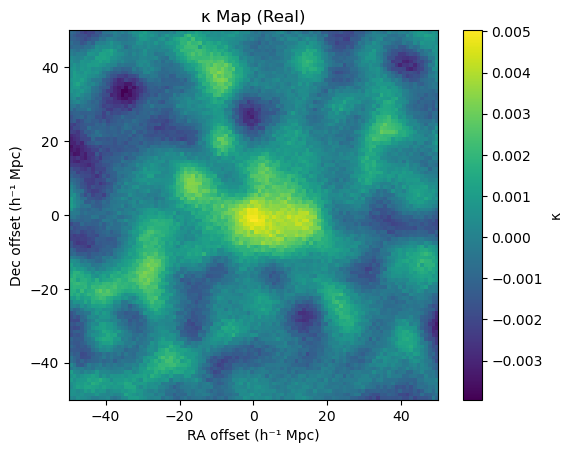

In [12]:
# --- Plots ---
plot_map(kappa_real, "κ Map (Real)")

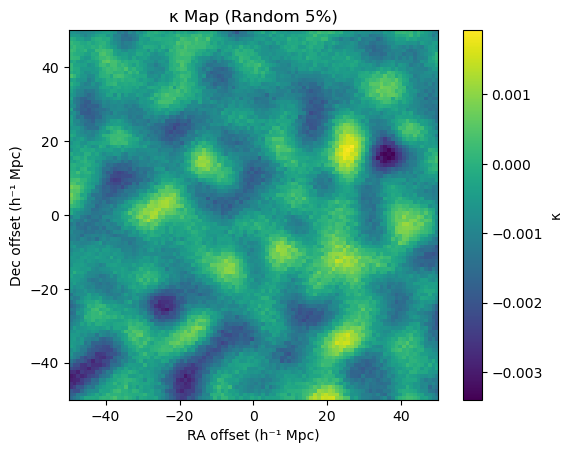

In [13]:
plot_map(kappa_rand, "κ Map (Random 5%)")

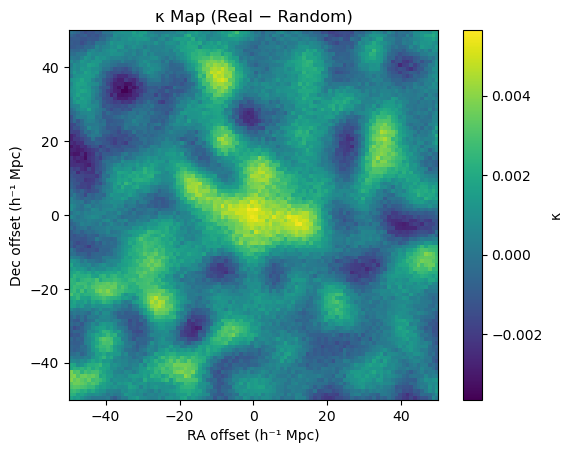

In [14]:
plot_map(kappa_sub, "κ Map (Real − Random)")

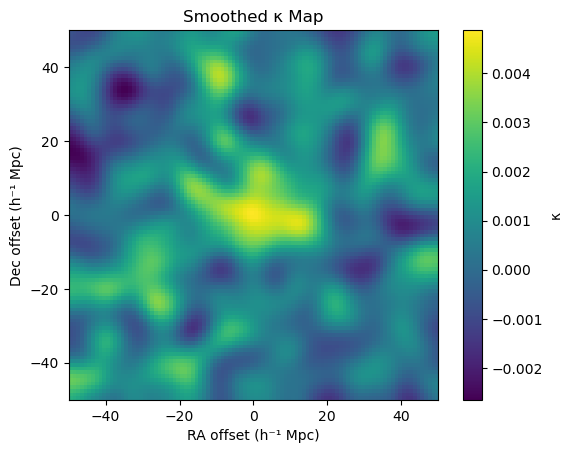

In [15]:
plot_map(kappa_smooth, "Smoothed κ Map", cmap='viridis')

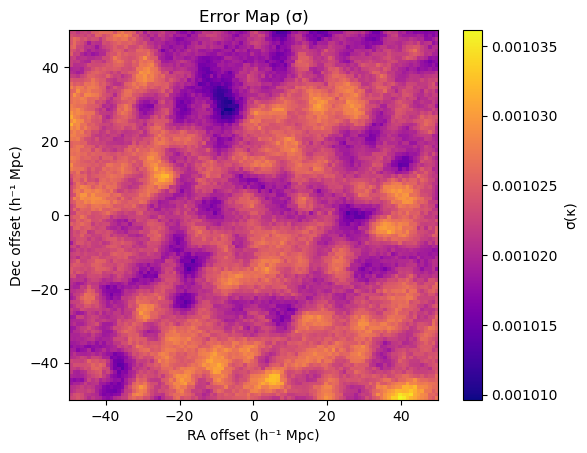

In [16]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

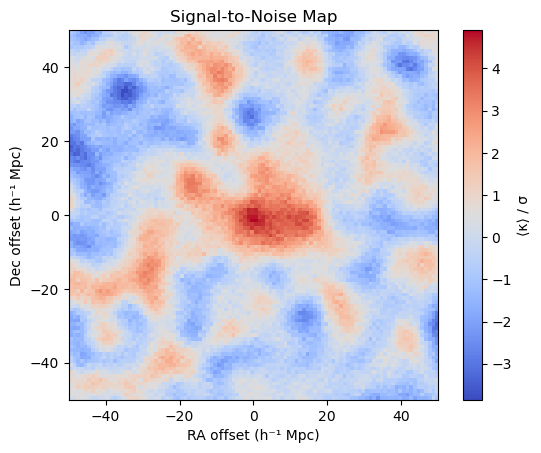

In [17]:
plot_map(sn_real, "Signal-to-Noise Map", cmap='coolwarm', label='⟨κ⟩ / σ')

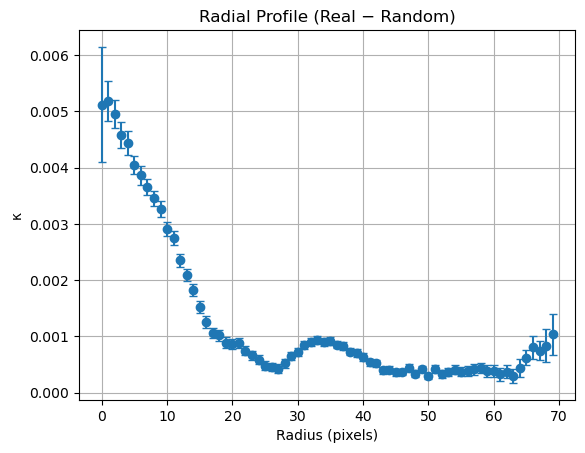

In [19]:
radial_profile(kappa_sub, sigma_real, "Radial Profile (Real − Random)", zoom=70)

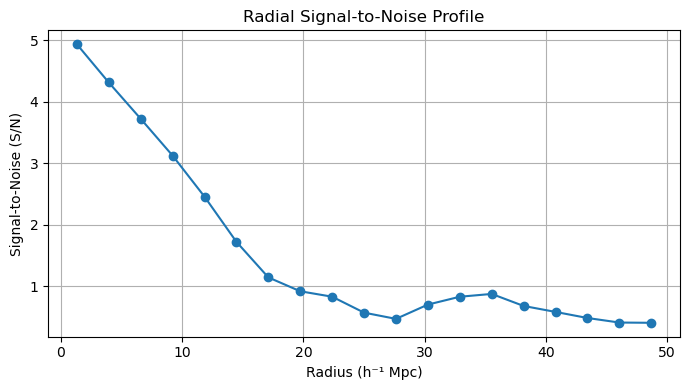

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Use your existing stacked maps here:
kappa_mean = kappa_sub       # 2D array, shape (grid_size, grid_size)
kappa_sigma = sigma_real     # 2D array, same shape

grid_size = kappa_mean.shape[0]  # e.g. 100
box_size_hmpc = 100  # your box size in h^-1 Mpc

# Create coordinate grids in Mpc
x = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
y = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
X, Y = np.meshgrid(x, y)

# Compute radius from center in Mpc
R = np.sqrt(X**2 + Y**2)

# Flatten arrays for binning
r_flat = R.ravel()
signal_flat = kappa_mean.ravel()
sigma_flat = kappa_sigma.ravel()

# Define radial bins (e.g., 20 bins up to 50 Mpc)
bin_edges = np.linspace(0, box_size_hmpc/2, 20)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Digitize radii to bins
inds = np.digitize(r_flat, bin_edges)

# Compute S/N per bin
sn_profile = []
for i in range(1, len(bin_edges)):
    in_bin = (inds == i)
    if np.any(in_bin):
        mean_signal = np.mean(signal_flat[in_bin])
        mean_sigma = np.sqrt(np.mean(sigma_flat[in_bin]**2))
        sn_profile.append(mean_signal / mean_sigma if mean_sigma > 0 else 0)
    else:
        sn_profile.append(0)

# Plot radial S/N profile
plt.figure(figsize=(7,4))
plt.plot(bin_centers, sn_profile, marker='o')
plt.xlabel('Radius (h⁻¹ Mpc)')
plt.ylabel('Signal-to-Noise (S/N)')
plt.title('Radial Signal-to-Noise Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Diagnostics ---
print("Diagnostics:")
print(f"κ min: {np.min(kappa_sub):.4g}, max: {np.max(kappa_sub):.4g}")
print(f"σ min: {np.min(sigma_real):.4g}, max: {np.max(sigma_real):.4g}")
print(f"S/N min: {np.min(sn_real):.4g}, max: {np.max(sn_real):.4g}")